In [1]:
from utils.binaries import *
from utils.plotting import *

13:20:57 (   +2.7s) [INFO   ] -- import logging
13:20:57 (  +148ms) [INFO   ] -- import numpy as np
13:20:57 (    +8ms) [INFO   ] -- import uncertainties
13:20:57 (  +274ms) [INFO   ] -- import pandas as pd
13:20:57 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
13:20:57 (    +1ms) [INFO   ] -- import binaries.tools as tools
13:20:57 (  +355ms) [INFO   ] -- import matplotlib.pyplot as plt
13:20:58 (  +508ms) [INFO   ] -- import seaborn as so
13:20:58 (    +2ms) [INFO   ] -- import plotting.tools as plot
13:20:58 (    +8ms) [DEBUG  ] -- font size set to 9.5
13:20:58 (    +1ms) [DEBUG  ] -- label size set to 13.0
13:20:58 (    +0ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
13:20:58 (    +1ms) [DEBUG  ] -- markersize set to 2.0
13:20:58 (    +1ms) [DEBUG  ] -- usetex set to False


In [2]:
import polars as pl

In [3]:
wind_data = pl.read_csv(
    'wind_directions.dat',
    comment_prefix='#',
)
wind_data[0, 'Direction'] = '355-364'
print(wind_data)


shape: (36, 8)
┌───────────┬───────┬────────┬────────┬────────┬──────────┬──────────┬───────┐
│ Direction ┆ Calm  ┆ 2.04.9 ┆ 5.06.9 ┆ 7.09.9 ┆ 10.014.9 ┆ 15.019.9 ┆ 20.0+ │
│ ---       ┆ ---   ┆ ---    ┆ ---    ┆ ---    ┆ ---      ┆ ---      ┆ ---   │
│ str       ┆ f64   ┆ f64    ┆ f64    ┆ f64    ┆ f64      ┆ f64      ┆ f64   │
╞═══════════╪═══════╪════════╪════════╪════════╪══════════╪══════════╪═══════╡
│ 355-364   ┆ 29.69 ┆ 2.652  ┆ 1.653  ┆ 0.581  ┆ 0.346    ┆ 0.064    ┆ 0.013 │
│ 005-014   ┆ null  ┆ 0.0    ┆ 0.0    ┆ 0.0    ┆ 0.0      ┆ 0.0      ┆ 0.013 │
│ 015-024   ┆ null  ┆ 1.025  ┆ 1.217  ┆ 0.521  ┆ 0.372    ┆ 0.021    ┆ 0.009 │
│ 025-034   ┆ null  ┆ 0.004  ┆ 0.0    ┆ 0.0    ┆ 0.0      ┆ 0.0      ┆ 0.0   │
│ 035-044   ┆ null  ┆ 0.009  ┆ 0.0    ┆ 0.0    ┆ 0.0      ┆ 0.0      ┆ 0.0   │
│ …         ┆ …     ┆ …      ┆ …      ┆ …      ┆ …        ┆ …        ┆ …     │
│ 305-314   ┆ null  ┆ 0.0    ┆ 0.0    ┆ 0.0    ┆ 0.0      ┆ 0.0      ┆ 0.0   │
│ 315-324   ┆ null  ┆ 1.862  ┆ 1.072 

In [4]:
wind_data = wind_data.with_columns(
    pl.col('Direction').str.split('-')
    .list.eval(pl.element().cast(pl.Int64))
    .alias('dir_range')).with_columns(
    mean = pl.col('dir_range').list.mean()
).select(
    'mean', '2.04.9', '5.06.9', '7.09.9', '10.014.9', '15.019.9', '20.0+'
).with_columns(
    cumsum=pl.cum_sum_horizontal(pl.exclude('mean'))
)

print(wind_data)

shape: (36, 8)
┌───────┬────────┬────────┬────────┬──────────┬──────────┬───────┬─────────────────────────────────┐
│ mean  ┆ 2.04.9 ┆ 5.06.9 ┆ 7.09.9 ┆ 10.014.9 ┆ 15.019.9 ┆ 20.0+ ┆ cumsum                          │
│ ---   ┆ ---    ┆ ---    ┆ ---    ┆ ---      ┆ ---      ┆ ---   ┆ ---                             │
│ f64   ┆ f64    ┆ f64    ┆ f64    ┆ f64      ┆ f64      ┆ f64   ┆ struct[6]                       │
╞═══════╪════════╪════════╪════════╪══════════╪══════════╪═══════╪═════════════════════════════════╡
│ 359.5 ┆ 2.652  ┆ 1.653  ┆ 0.581  ┆ 0.346    ┆ 0.064    ┆ 0.013 ┆ {2.652,4.305,4.886,5.232,5.296, │
│       ┆        ┆        ┆        ┆          ┆          ┆       ┆ 5…                              │
│ 9.5   ┆ 0.0    ┆ 0.0    ┆ 0.0    ┆ 0.0      ┆ 0.0      ┆ 0.013 ┆ {0.0,0.0,0.0,0.0,0.0,0.013}     │
│ 19.5  ┆ 1.025  ┆ 1.217  ┆ 0.521  ┆ 0.372    ┆ 0.021    ┆ 0.009 ┆ {1.025,2.242,2.763,3.135,3.156, │
│       ┆        ┆        ┆        ┆          ┆          ┆       ┆ 3…       

In [25]:
def wind_rose(xs, ys, palette='plasma'):

    # set_plt_style('dark')
    fig, ax = plt.subplots(subplot_kw={"projection":"polar"})
    cmap = plt.get_cmap(palette)
    colors = cmap(np.linspace(0.5, 1, 6))
    ranges = ['03-08', '08-11', '11-16', '16-24' ,'24-32', '32$+$  ']

    for x, heights in zip(xs, ys): 
        heights = list(heights.values())

        for i, height in enumerate(heights):
            ax.bar(np.pi/180 * (90-x), height, color=colors[-i-1], zorder=10-i, width=0.15, bottom=4)

    for i in range(6):
        ax.fill_between([], [], [], color=colors[-i-1], label=fr'{ranges[i]} $\mathrm{{m}}$/$\mathrm{{s}}$')

    ax.grid(visible=False)
    ax.set_ylim(0)
    ax.set_yticks([])
    ax.set_xticks(np.pi/180 * np.array([0, 45, 90, 135, 180, 225, 270, 315]), ['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=1)


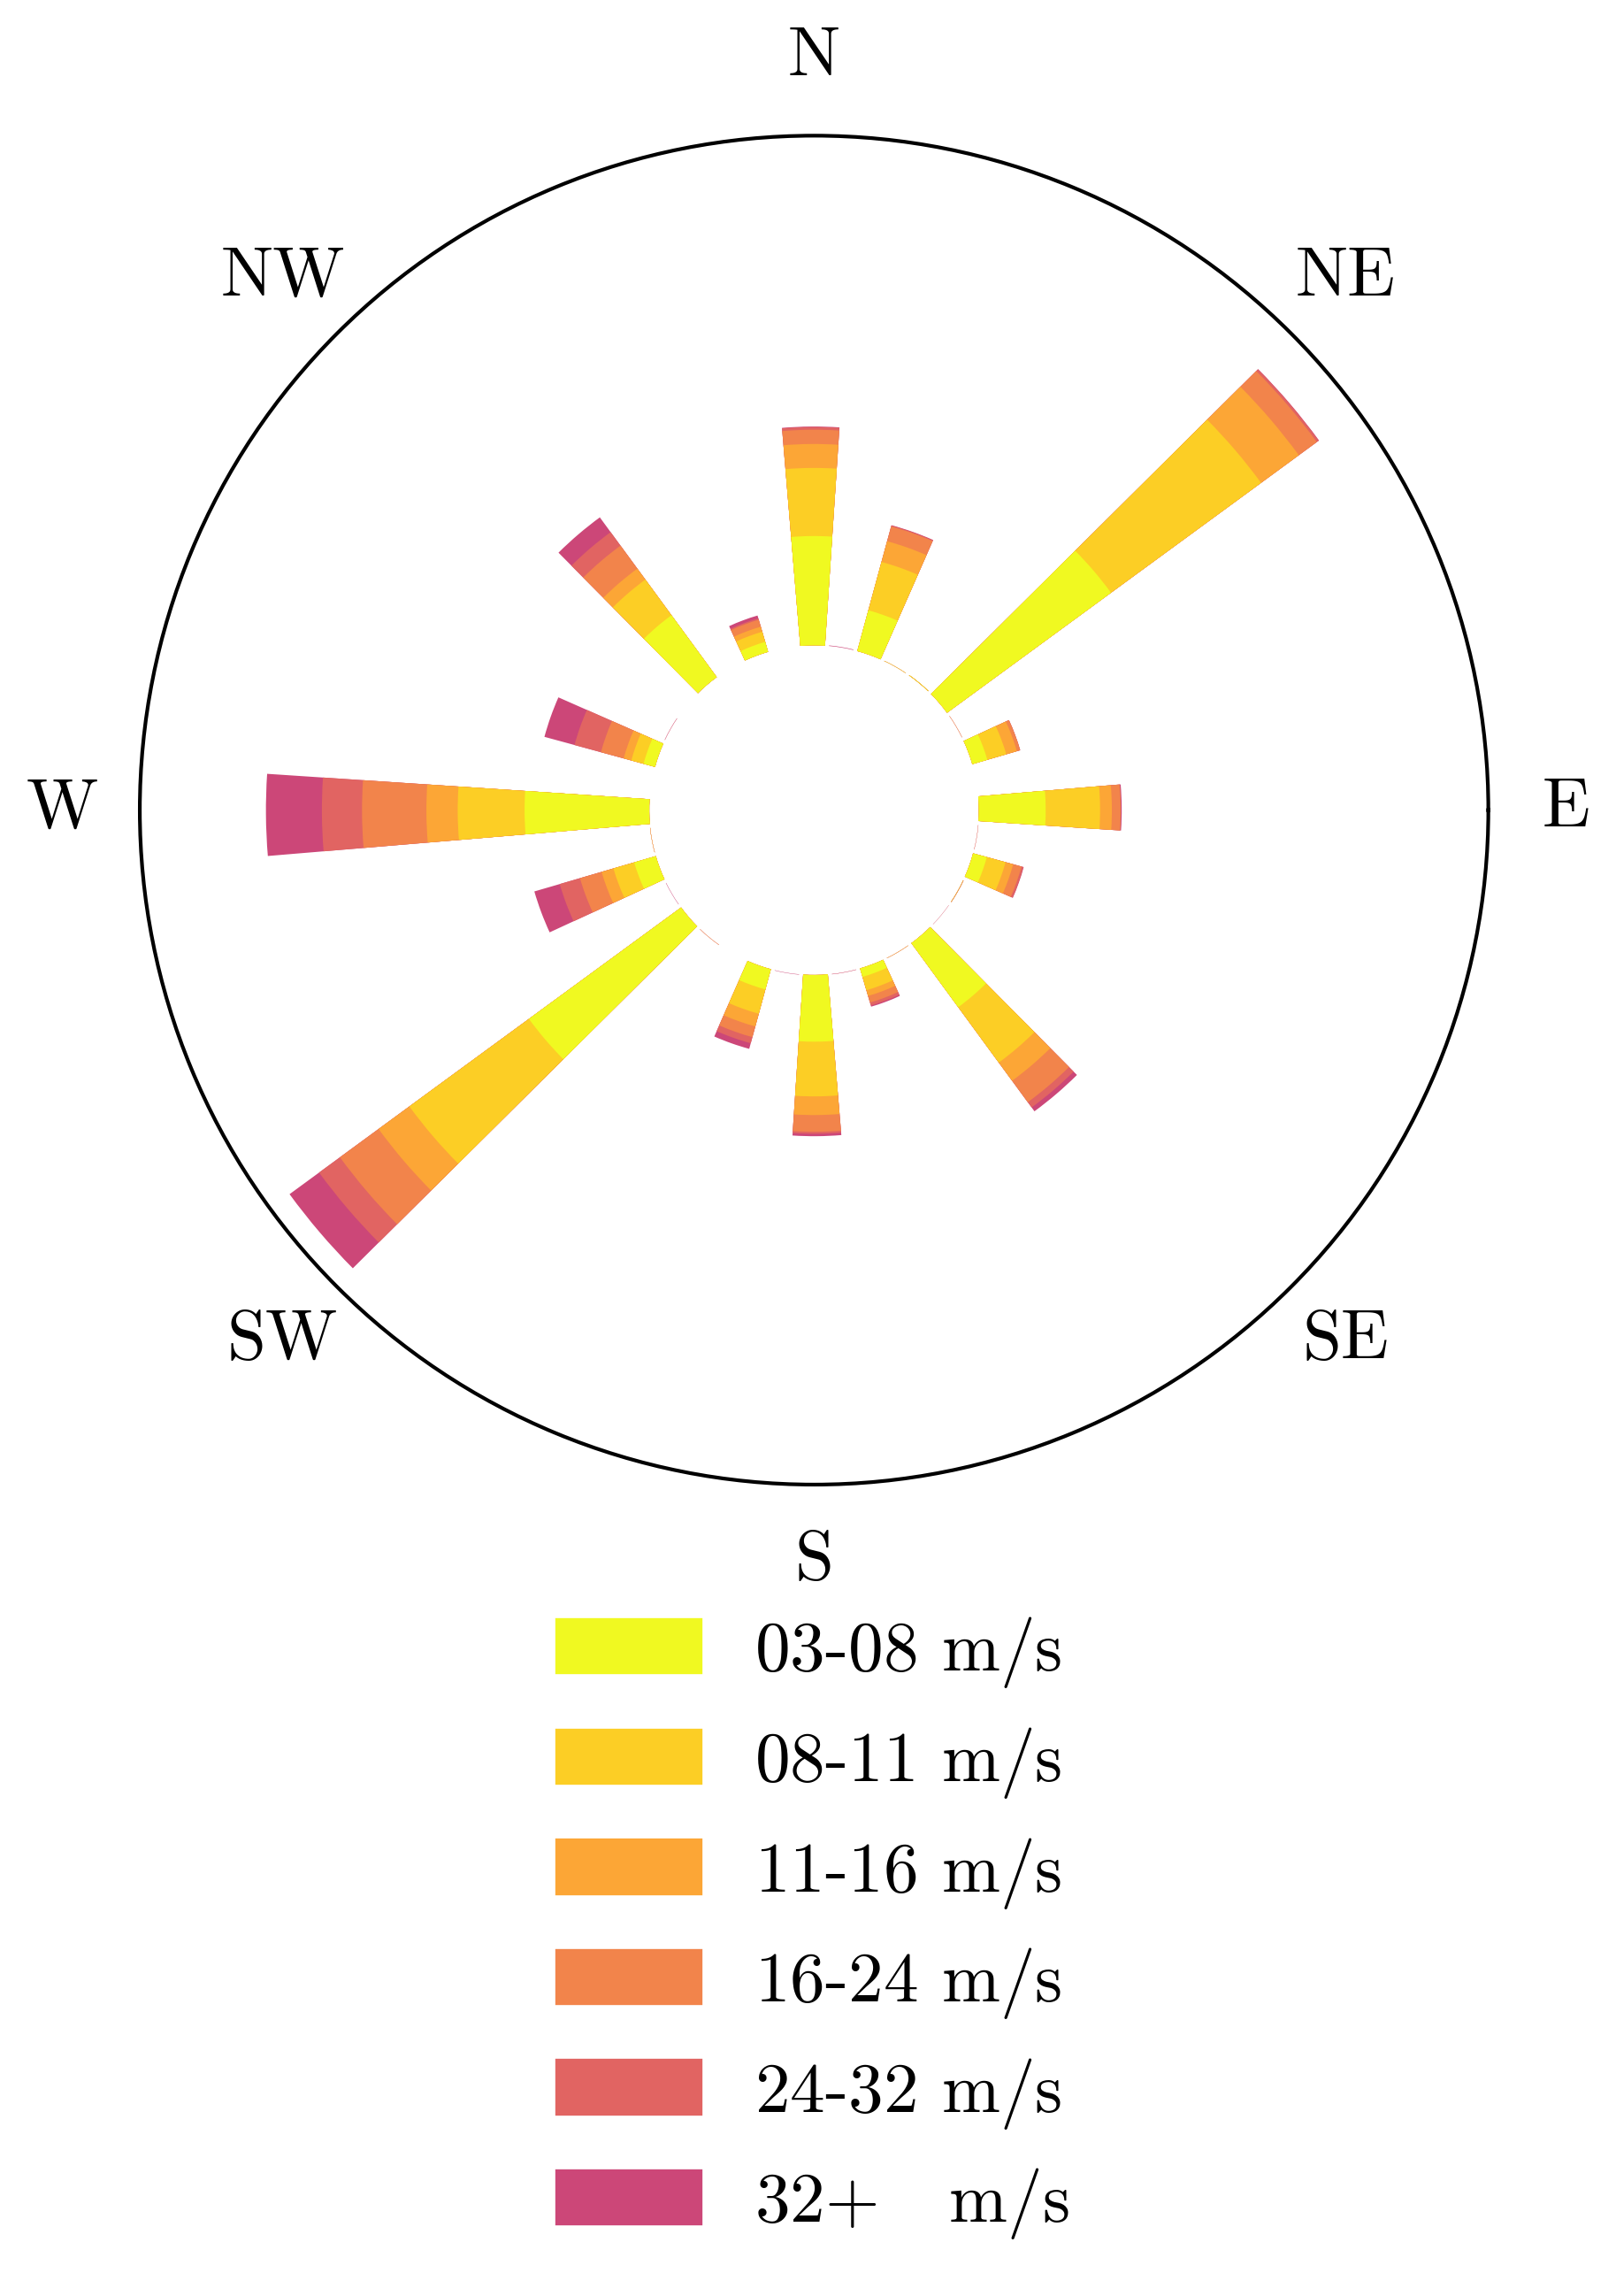

In [26]:
wind_rose(wind_data['mean'], wind_data['cumsum'])
# plot.save(path='malargue_wind_rose')